In [0]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir("/content/gdrive/My Drive/Competition/final_data")

In [0]:
X = np.load("re_arr.npy")
Y = np.load("re_label.npy", allow_pickle=True)

In [0]:
X = X.reshape((-1, 150, 150, 3))

In [0]:
from sklearn.preprocessing import OneHotEncoder
Y = Y.reshape((-1, 1))
enc = OneHotEncoder()
enc.fit(Y)
Y = enc.transform(Y).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
print(X.shape, Y.shape)

(14034, 150, 150, 3) (14034, 6)


In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # warning 출력 방지
from keras.applications.resnet50 import ResNet50, decode_predictions
resnet = ResNet50(weights='imagenet', include_top = False, input_shape = (150, 150, 3), pooling="max")
resnet.summary()

94658560/94653016 [==============================] - 11s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
_________________________

In [0]:
import tensorflow as tf

def my_leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)

In [0]:
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, ZeroPadding2D, Conv2D
from keras.models import Model
from keras.regularizers import l2


x = resnet.layers[38].output

x = ZeroPadding2D(padding=(1, 1))(x)
x = Conv2D(filters=1024, kernel_size=(3, 3), activation=my_leaky_relu)(x)

x = Dropout(0.80)(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation=my_leaky_relu, kernel_initializer="he_normal", kernel_regularizer=l2(0.55))(x)
x = Dropout(0.80)(x)
x = BatchNormalization()(x)

Predictions = Dense(6, activation="softmax")(x)  
model = Model(inputs=resnet.input, outputs=Predictions)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

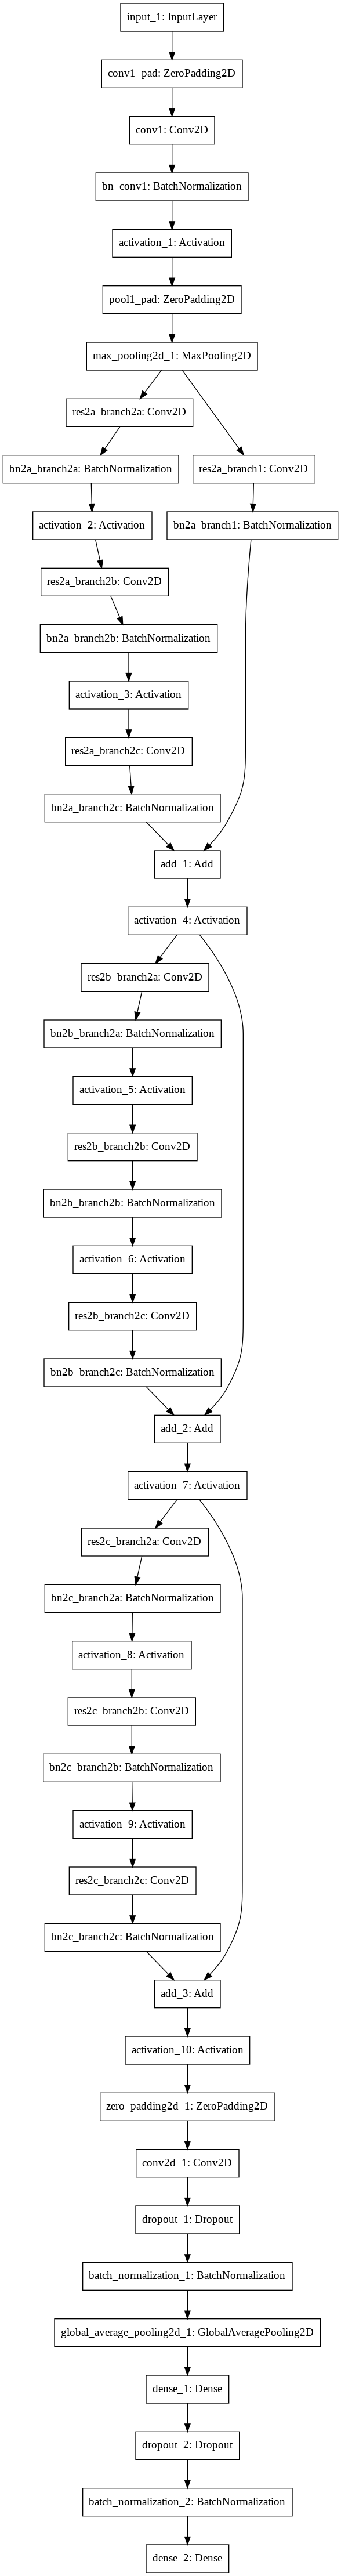

In [0]:
from keras.utils import plot_model
plot_model(model,expand_nested = False)

In [0]:
!pip install keras-rectified-adam
#len(model.layers)

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=024c8c0c94d11b78df455a3bc6be5d690cca00970cb57bc8b53c57b5c814611b
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [0]:
from keras_radam import RAdam
model.compile(optimizer=RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
from sklearn.model_selection import KFold
import time
start_ = time.time()

kfold = KFold(n_splits=5, shuffle=True)

accuracy = []

for train, validation in kfold.split(X, Y) :
    model.fit(X[train], Y[train], epochs=20, verbose =1, shuffle=True)
    acc = model.evaluate(X[validation], Y[validation])[1]
    accuracy.append(acc)

print("소요시간:", time.time() - start_)

Epoch 1/20
11227/11227 [==============================] - 47s 4ms/step - loss: 936.7787 - acc: 0.5121
Epoch 2/20
11227/11227 [==============================] - 38s 3ms/step - loss: 207.6767 - acc: 0.7502
Epoch 3/20
11227/11227 [==============================] - 38s 3ms/step - loss: 4.8054 - acc: 0.8097
Epoch 4/20
11227/11227 [==============================] - 38s 3ms/step - loss: 1.0126 - acc: 0.8252
Epoch 5/20
11227/11227 [==============================] - 38s 3ms/step - loss: 0.9653 - acc: 0.8335
Epoch 6/20
11227/11227 [==============================] - 38s 3ms/step - loss: 0.9305 - acc: 0.8481
Epoch 7/20
11227/11227 [==============================] - 38s 3ms/step - loss: 0.9617 - acc: 0.8420
Epoch 8/20
11227/11227 [==============================] - 38s 3ms/step - loss: 0.9442 - acc: 0.8511
Epoch 9/20
11227/11227 [==============================] - 38s 3ms/step - loss: 0.9105 - acc: 0.8595
Epoch 10/20
11227/11227 [==============================] - 38s 3ms/step - loss: 0.9380 - acc: 0.

In [0]:
print(accuracy)

[0.8628429174423218, 0.9693623185157776, 0.9907374382019043, 0.9935874342918396, 0.9960798025131226]


In [0]:
np.mean(accuracy)

0.9625219821929931

In [0]:
testx = np.load("test_plz.npy")
test = testx/255.0

testid = np.load("test_id_plz.npy", allow_pickle=True)

In [0]:
test.shape

(3000, 150, 150, 3)

In [0]:
pred = model.predict(test)
label = np.argmax(pred, axis=-1)

In [0]:
test_id = np.load("test_id_plz.npy", allow_pickle=True)

answer = pd.DataFrame(columns=["id", "pred_label"])
answer["id"] = [x[0] for x in test_id.tolist()]
answer["pred_label"] = label

answer.to_csv("predictionDropoutCopy.csv", index=False)

In [0]:
## acc: 

In [0]:
#confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_id,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx,classes = range(6)) 